# Imports/Set up

In [1]:
# Specific to NERSC: Set up kernel using: https://docs.nersc.gov/services/jupyter/how-to-guides/
from __future__ import annotations

import sys

import pandas as pd
import torch

# might have issues with too many files being opened at once
# this will prevent that
import torch.multiprocessing
from landscaper import LossLandscape
from landscaper import PyHessian
from neuralop import H1Loss
from neuralop import LpLoss
from neuralop.data.datasets.darcy import DarcyDataset
from neuralop.data.transforms.data_processors import IncrementalDataProcessor
from neuralop.models import FNO
from neuralop.training import AdamW
from neuralop.training.incremental import IncrementalFNOTrainer
from neuralop.utils import count_model_params
from neuralop.utils import get_project_root
from torch.utils.data import DataLoader

torch.multiprocessing.set_sharing_strategy('file_system')

root_dir = get_project_root() / 'neuralop/data/datasets/data'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'{device=}')

FIG_DIR = '../figures'

device=device(type='cuda')


# Train FNO

In [2]:
# first download data
data = DarcyDataset(
    root_dir=root_dir,
    n_train=100,
    n_tests=[32, 32, 32, 32],
    batch_size=16,
    test_batch_sizes=[16, 16, 16, 16],
    train_resolution=128,  # change resolution to download different data
    test_resolutions=[16, 32, 64, 128],
)

Loading test db for resolution 16 with 32 samples 
Loading test db for resolution 32 with 32 samples 
Loading test db for resolution 64 with 32 samples 
Loading test db for resolution 128 with 32 samples 


In [3]:
# load darcy flow dataset


def load_darcy_flow_small(
    n_train,
    n_tests,
    data_root=root_dir,
    test_resolutions=(16, 32),
    train_resolution=16,
):
    """Docstring."""
    batch_size = 16
    test_batch_sizes = [batch_size] * len(test_resolutions)

    dataset = DarcyDataset(
        root_dir=data_root,
        n_train=n_train,
        n_tests=n_tests,
        batch_size=batch_size,
        test_batch_sizes=test_batch_sizes,
        train_resolution=train_resolution,
        test_resolutions=test_resolutions,
        encode_input=False,
        encode_output=True,
        channel_dim=1,
        encoding='channel-wise',
        download=True,
    )

    # return dataloaders for backwards compat
    train_loader = DataLoader(
        dataset.train_db,
        batch_size=batch_size,
        num_workers=1,
        pin_memory=True,
        persistent_workers=False,
    )

    test_loaders = {}
    for res, test_bsize in zip(test_resolutions, test_batch_sizes):
        test_loaders[res] = DataLoader(
            dataset.test_dbs[res],
            batch_size=test_bsize,
            shuffle=False,
            num_workers=1,
            pin_memory=True,
            persistent_workers=False,
        )

    return train_loader, test_loaders, dataset.data_processor

In [4]:
df = pd.DataFrame(
    columns=[
        'train_resolution',
        'test_resolution',
        'loss_type',
        'loss',
        'max_modes',
    ],
)
max_modes = 16
train_resolution = 16

# get data
train_loader, test_loaders, output_encoder = load_darcy_flow_small(
    n_train=1000,
    # batch_size=16,
    train_resolution=train_resolution,
    test_resolutions=[16, 32, 64, 128],
    n_tests=[100, 100, 100, 100],
    # test_batch_sizes=[32, 32, 32, 32],
)

# incrementally vary modes
incremental = True
starting_modes = (max_modes, max_modes)
if incremental:
    starting_modes = (2, 2)

# Set up model
model = FNO(
    max_n_modes=(max_modes, max_modes),
    n_modes=starting_modes,
    hidden_channels=32,
    in_channels=1,
    out_channels=1,
)
model = model.to(device)
n_params = count_model_params(model)

# optimizer + data
optimizer = AdamW(model.parameters(), lr=8e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

data_transform = IncrementalDataProcessor(
    in_normalizer=None,
    out_normalizer=None,
    device=device,
    subsampling_rates=[2, 1],
    dataset_resolution=16,
    dataset_indices=[2, 3],
    epoch_gap=10,
    verbose=True,
)

data_transform = data_transform.to(device)

l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)
train_loss = h1loss
eval_losses = {'h1': h1loss, 'l2': l2loss}
print('\n### N PARAMS ###\n', n_params)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print('\n### INCREMENTAL RESOLUTION + GRADIENT EXPLAINED ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()

# Finally pass all of these to the Trainer
trainer = IncrementalFNOTrainer(
    model=model,
    n_epochs=20,
    data_processor=data_transform,
    device=device,
    verbose=False,
    incremental_loss_gap=False,
    incremental_grad=True,
    incremental_grad_eps=0.9999,
    incremental_loss_eps=0.001,
    incremental_buffer=5,
    incremental_max_iter=1,
    incremental_grad_max_iter=2,
)

# train
end_stats = trainer.train(
    train_loader,
    test_loaders,
    optimizer,
    scheduler,
    regularizer=False,
    training_loss=train_loss,
    eval_losses=eval_losses,
)

model = trainer.model

Loading test db for resolution 16 with 100 samples 
Loading test db for resolution 32 with 100 samples 
Loading test db for resolution 64 with 100 samples 
Loading test db for resolution 128 with 100 samples 
Original Incre Res: change index to 0
Original Incre Res: change sub to 2
Original Incre Res: change res to 8

### N PARAMS ###
 2110305

### OPTIMIZER ###
 AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-06
    initial_lr: 0.008
    lr: 0.008
    weight_decay: 0.0001
)

### SCHEDULER ###

### LOSSES ###

### INCREMENTAL RESOLUTION + GRADIENT EXPLAINED ###

 * Train: <neuralop.losses.data_losses.H1Loss object at 0x7f6bc075da50>

 * Test: {'h1': <neuralop.losses.data_losses.H1Loss object at 0x7f6bc075da50>, 'l2': <neuralop.losses.data_losses.LpLoss object at 0x7f6bc075d030>}
Incre Res Update: change index to 1
Incre Res Update: change sub to 1
Incre Res Update: change res to 16


# Loss Landscape Vis w/ un-modified library

In [5]:
model = model.eval()
model

FNO(
  (positional_embedding): GridEmbeddingND()
  (fno_blocks): FNOBlocks(
    (convs): ModuleList(
      (0-3): 4 x SpectralConv(
        (weight): DenseTensor(shape=torch.Size([32, 32, 16, 16]), rank=None)
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Flattened1dConv(
        (conv): Conv1d(32, 32, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
    (channel_mlp): ModuleList(
      (0-3): 4 x ChannelMLP(
        (fcs): ModuleList(
          (0): Conv1d(32, 16, kernel_size=(1,), stride=(1,))
          (1): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
        )
      )
    )
    (channel_mlp_skips): ModuleList(
      (0-3): 4 x SoftGating()
    )
  )
  (lifting): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
    )
  )
  (projection): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64, 1, kernel_size=

In [6]:
def loss_function(model, data):
    """Custom loss func for loss landscape."""
    batch_loss = 0
    for _idx, sample in enumerate(data):  # resolution 128
        inputs, labels = sample
        inputs = inputs.to(device)
        labels = labels.to(device)
        # model_input = data_transform.preprocess(sample)
        with torch.no_grad():
            out = model(inputs)
            loss = criterion(out, labels)
            batch_loss += loss
    return batch_loss / len(data)


criterion = LpLoss(d=2, p=2)
net = model
inputs = []
labels = []
for _idx, sample in enumerate(test_loaders[128]):  # resolution 128
    inputs.append(sample['x'])
    labels.append(sample['y'])


inputs = torch.cat(inputs).to(device)
labels = torch.cat(labels).to(device)

data = []
for x, y in zip(inputs, labels):
    data.append((x.unsqueeze(dim=0), y.unsqueeze(dim=0)))

loss_function(model, data)

tensor(0.3299, device='cuda:0')

In [7]:
def generate_random_orthogonal_directions(model, n=3):
    """Grab random directions for perturbing model."""
    directions = []
    while len(directions) != n:
        random_dir = [torch.randn_like(p.data) for p in model.parameters()]
        for prev_dir in directions:
            dot_product = sum(
                (d1 * d2).sum()
                for d1, d2 in zip(random_dir, prev_dir, strict=False)
            )

            for j, (d1, d2) in enumerate(
                zip(random_dir, prev_dir, strict=False)
            ):
                random_dir[j] = d1 - dot_product * d2
        directions.append(random_dir)
    return directions


directions = generate_random_orthogonal_directions(model, n=3)

In [8]:
hessian_comp = PyHessian(
    net,
    criterion,
    data,
    device,  # hessian_generator=generic_generator_a
)

with torch.backends.cudnn.flags(enabled=False):
    evals, evecs = hessian_comp.eigenvalues(top_n=3)

directions = evecs
evals

Complex parameters detected in model. Results will be complex tensors.


Eigenvectors computed: 100%|██████████| 3/3 [16:53<00:00, 337.70s/it]                  


[(63.84839630126953+0.002416933886706829j),
 (10.436812400817871+0.0012682370143011212j),
 (2.163118600845337+0.0014906456926837564j)]

In [18]:
with torch.backends.cudnn.flags(enabled=False):
    landscape = LossLandscape.compute(
        model,
        data,
        evecs,
        loss_function,  # loss function
        dim=2,
        distance=0.1,
        device=device,
        use_complex=True,
    )

Computing 1681 points in 2D space...


Computing 2D landscape: 100%|██████████| 1681/1681 [08:28<00:00,  3.31it/s]

Loss hypercube stats - min: 0.3181398808956146, max: 15.750319480895996, mean: 1.7337808956850291


In [19]:
landscape.save('fno_1_5.npz')
landscape = LossLandscape.load_from_npz('fno_1_5.npz')

Attempting log-scale surface plot...


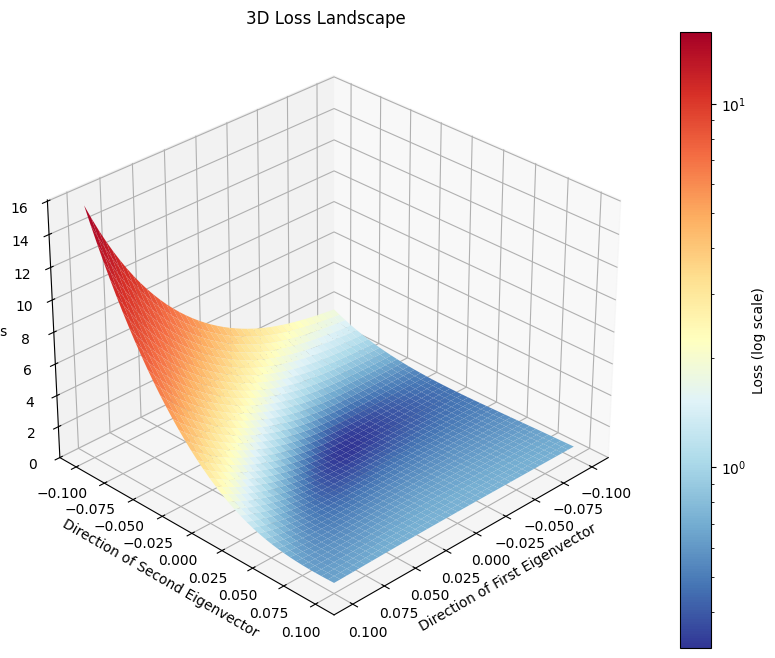

In [20]:
landscape.show()

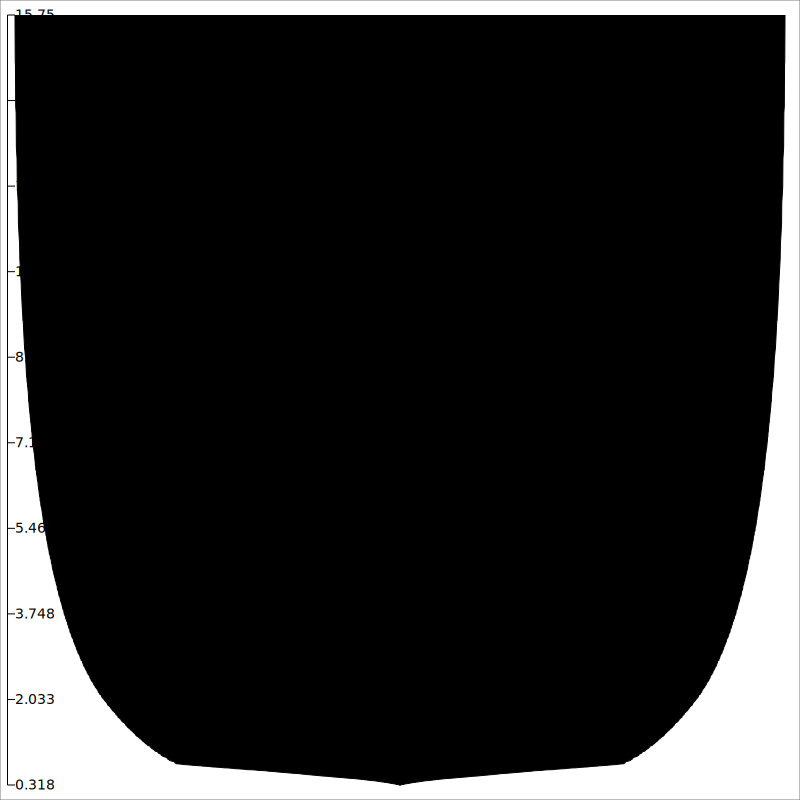

In [21]:
landscape.show_profile()

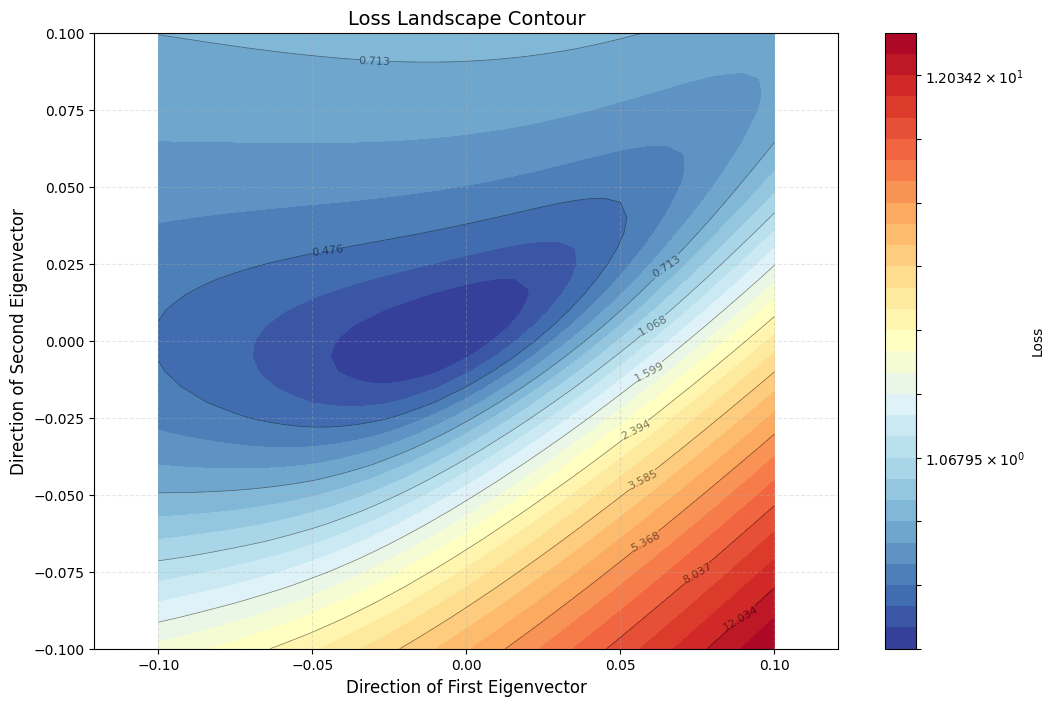

In [22]:
landscape.show_contour()

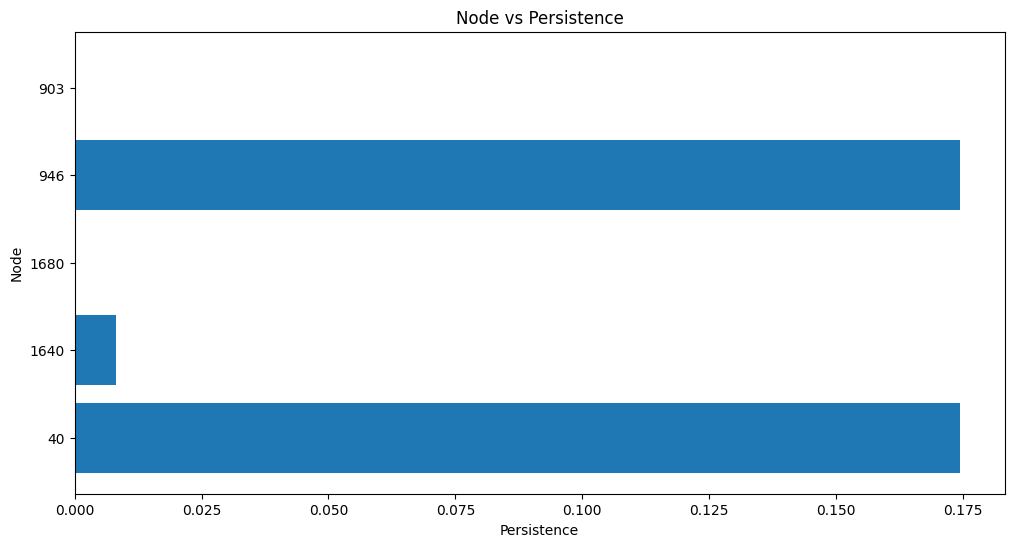

In [14]:
landscape.show_persistence_barcode()

In [15]:
# we can use this function to convert the merge tree
# into a networkx graph and visualize it!
from landscaper.tda import digraph_mt

g = digraph_mt(landscape.get_sublevel_tree())

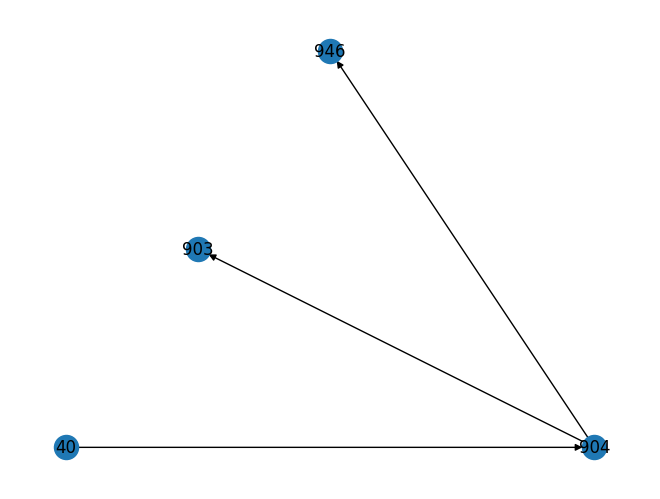

In [16]:
import networkx as nx

nx.draw_planar(g, with_labels=True)

In [17]:
complex_vals = any(torch.is_complex(p) for p in model.parameters())
print(f'Model has complex weights: {complex_vals}')

Model has complex weights: True
